# Google AI4Code – EDA as Binary Classification Task


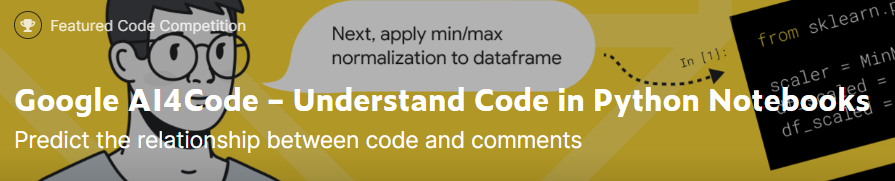


Thank you for your checking this notebook.

This is my EDA for "Google AI4Code – Understand Code in Python Notebooks" competition [(Link)](https://www.kaggle.com/competitions/AI4Code).

The task is to identify correct position of Markdown cells in sequence of code cells which are ordered correctly.

So my first approach is to prepare two types "Correctly order" & "Not correctly order" of data for training and solve task as binary classification.

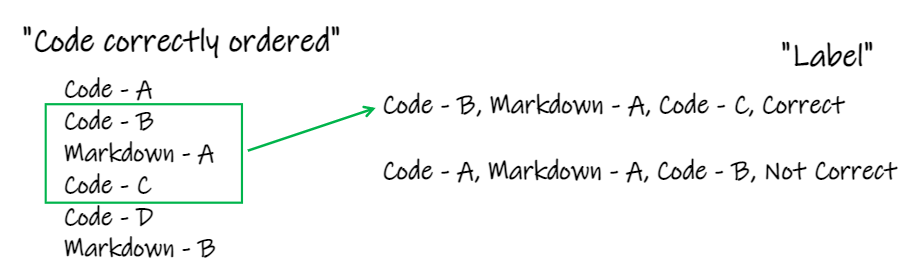

If you think this notebook is useful, please give your comment or question and I appreciate your upvote as well. :) 

<a id='top'></a>
## Contents
1. [Import Library & Set Config](#config)
2. [Load Data](#load)
3. [Preprocessing Data](#prep)
4. [tf-idf](#tfidf)
5. [Latent Dirichlet Allocation](#lda)
6. [Wordcloud](#wordcloud)
7. [TruncatedSVD](#svd)
8. [t-sne](#tsne)
9. [UMAP](#umap)
10. [Cosine Similality](#cosi)
11. [Conclusion](#conclusion)
12. [Reference](#ref)


<a id='config'></a>

---
# 1. Import Library & Set Config
---

[Back to Contents](#top)

In [1]:
!pip install mglearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for mglearn: filename=mglearn-0.1.9-py2.py3-none-any.whl size=582639 sha256=d186b666c8663f994c2313856b2ccf600bffb099b47dc4384dcebe8a897f00ba
  Stored in directory: /root/.cache/pip/wheels/f1/17/e1/1720d6dcd70187b6b6c3750cb3508798f2b1d57c9d3214b08b
Successfully built mglearn


In [2]:
# General
import sys, warnings, time, os, copy, gc, re, random, json
import pickle as pkl
warnings.filterwarnings('ignore')
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
# pd.set_option("display.max_colwidth", 10000)
import seaborn as sns
sns.set()
from pandas.io.json import json_normalize
from pprint import pprint
from pathlib import Path
from tqdm import tqdm
tqdm.pandas()
from datetime import datetime, timedelta
from scipy import sparse
import mglearn

# Pre-Processing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from jrstc_util import cleanse_text_new, text_cleaning, clean
from wordcloud import WordCloud, STOPWORDS
import umap

# Model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

Looking in links: ../input/contractions/pyahocorasick-1.4.2/pyahocorasick-1.4.2.tar
Processing /kaggle/input/contractions/pyahocorasick-1.4.2/pyahocorasick-1.4.2.tar
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=106884 sha256=aecb3ef20d9ef8e839a7686424c8685865278ecf949049ed92930c1763afa1f0
  Stored in directory: /root/.cache/pip/wheels/28/6a/80/2e62a80b58ca548cc1b4c039fa2da873dcec052632daac5894
Successfully built pyahocorasick


Looking in links: ../input/contractions
Processing /kaggle/input/contractions/contractions-0.0.58-py2.py3-none-any.whl
Processing /kaggle/input/contractions/textsearch-0.0.21-py2.py3-none-any.whl
Processing /kaggle/input/contractions/anyascii-0.3.0-py3-none-any.whl


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Hi!


In [3]:
# Configuration
DEBUG = False
PATH_INPUT = Path('../input/AI4Code')
SAMPLE_ID = '051d049a469e47'

if DEBUG:
    NUM_SAMPLE = 10
    # NUM_SAMPLE = 1000
    
else:
    NUM_SAMPLE = 2000

In [4]:
def dump_load(obj, fileName, mode):
    if mode == 'wb':
        with open(fileName, mode=mode) as f:
            pkl.dump(obj, f)
            
    elif mode == 'rb':
        with open(fileName, mode=mode) as f:
            x = pkl.load(f)
            
            return x
            
    else:
        print('Please give "wb" or "rb" as mode.')

<a id='load'></a>

---
# 2. Load Data

Data discription page [Link](https://www.kaggle.com/competitions/AI4Code/data) explained that their mainly two folders for training and test are prepared. 

The train folder contains about 140,000 JSON files which contains the code and markdown cells. The correct order of them are described in train_orders.csv.

The test folder contains only 4 JSON files for testing our code. The contents inside of this folder will be replaced by actual test set when the notebook is submitted.

In this notebook, as demostration checking the data based on sampling from train data.

---

[Back to Contents](#top)

In [5]:
def read_notes(path):
    df = pd.read_json(path,
                     dtype={'cell_type': 'category', 'source': 'str'}
                     )
    df = df.assign(id=path.stem).rename_axis('cell_id')
    
    return df

In [6]:
listTrainPaths = list((PATH_INPUT / 'train').glob('*.json'))[:NUM_SAMPLE]
listTrainNotes = [read_notes(path) for path in tqdm(listTrainPaths)]
dfTrain = pd.concat(listTrainNotes)
dfTrain = dfTrain.set_index('id', append=True)
dfTrain = dfTrain.swaplevel().sort_index(level='id', sort_remaining=False)
dfTrain

100%|██████████| 2000/2000 [00:23<00:00, 83.85it/s]


cell_type  \
id             cell_id              
00103dc8bd5781 7c1153a3      code   
               4ac2dd22      code   
               1825504f      code   
               9b59a97c      code   
               30db29da      code   
...                           ...   
fffc63ff750064 56aa8da7      code   
               411b85d9  markdown   
               e7e67119  markdown   
               8b54cf58  markdown   
               b3c6bc16  markdown   

                                                                                                                                                                                                                  source  
id             cell_id                                                                                                                                                                                                    
00103dc8bd5781 7c1153a3                                                                              import numpy as np\nimport pandas as pd\nimport matplotlib.pyplot as plt\nimport seaborn as sns\n%matplotlib inline  
               4ac2dd22                                                                                                         df = pd.read_csv('../input/customer-segmentation-tutorial-in-python/Mall_Customers.csv')  
               1825504f                                                                                                                                                                                               df  
               9b59a97c                                                                                                                                                                                        df.info()  
               30db29da  plt.figure(figsize=(18, 11))\nmatrix = np.triu(df.corr())\nsns.heatmap(df.corr(),center= 0, annot=True, linewidth=0.8, mask=matrix)\n\nplt.title('Features Correlation Heatmap', fontsize = 25)  
...                                                                                                                                                                                                                  ...  
fffc63ff750064 56aa8da7                                                                                                                                         \nsubmission.to_csv('house_price_rf.csv', index = False)  
               411b85d9                                                                                                                                                                            1. # Data exploration  
               e7e67119                                                                                                                                                                           # # Data preprocessing  
               8b54cf58                                                                                                                                                                    # Post-process for submission  
               b3c6bc16                                                                                                                                                                           # Define and fit model  

[92286 rows x 2 columns]

In [7]:
dfOrders = pd.read_csv((PATH_INPUT / 'train_orders.csv'), index_col='id', squeeze=True)
dfOrders = dfOrders.str.split()
dfOrders

id
00001756c60be8                                                                                                                                                                                                                                                                                                                                                                                                                                             [1862f0a6, 448eb224, 2a9e43d6, 7e2f170a, 038b763d, 77e56113, 2eefe0ef, 1ae087ab, 0beab1cd, 8ffe0b25, 9a78ab76, 0d136e08, 8a4c95d1, 23705731, ebe125d5, aaad8355, d9dced8b, 21616367, 86497fe1, c3ce0945, e2c8e725, a6357f7e, ff7c44ed, ac301a84, 0e7c906e, dd0c804a, 45082c89, 781bbf3c, 4bb2e30a, bd94f005, 63c26fa2, 62638fba, 3e5f860d, bb69e88c, 6b5664c7, 3eebeb87, 23783525, 36002912, bfbde93e, 8522781a, 1496beaf, 8ca8392c, b69a4f9b, 17ec3fc4, 503926eb, 76512d50, 032e2820, a98c5d9f, 06365725, 8554b284, 59959af5, 2e1a5949, 80151ab7, fcb6792d, 5bf9ca51, 915

In [8]:
dfSample = dfTrain.loc[SAMPLE_ID, :]
numCode = dfSample[dfSample['cell_type'] == 'code'].shape[0]
numMark = dfSample[dfSample['cell_type'] == 'markdown'].shape[0]
print(f'Notebook {SAMPLE_ID} has {numCode} code cells and {numMark} markdown cells. \n')
dfSample

Notebook 051d049a469e47 has 52 code cells and 39 markdown cells. 



cell_type  \
cell_id              
d7e4aeec      code   
aeb2a838      code   
12c1a908      code   
e7e68995      code   
320bedc7      code   
...            ...   
61a146d1  markdown   
0d7a91e3  markdown   
c0b25242  markdown   
1b7707e6  markdown   
503a84f0  markdown   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [9]:
listOrders = dfOrders.loc[SAMPLE_ID]
dfSample.loc[listOrders, :]

cell_type  \
cell_id              
c0b25242  markdown   
d7e4aeec      code   
cd6b2dda  markdown   
aeb2a838      code   
12c1a908      code   
...            ...   
3563f858      code   
7611ae31  markdown   
cd0d933d      code   
d943cd36      code   
66c450ba  markdown   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [10]:
del dfSample
gc.collect()

78

<a id='prep'></a>

---
# 3. Preprocessing Data

First, text in source column is cleansed by my util file.

Second, dataframe which have correctly ordered data is prepared and pick up markdown cell and two code cell before/after that. This data would have label, True (1).

Next, dataframe which have shuffled markdown cell position is prepared and pick up markdown cell and two code cell before/after that. This data would have label, False (0).

Then two dataframe are concatenated.

---

[Back to Contents](#top)

In [11]:
dfTrain['source'] = dfTrain['source'].progress_apply(cleanse_text_new)

100%|██████████| 92286/92286 [23:30<00:00, 65.41it/s]


In [12]:
listID = set(dfTrain.reset_index()['id'].tolist())

n = 1
for nbid in tqdm(listID):
    dfTemp = dfTrain.loc[nbid,:]
    listMD = dfTemp[dfTemp['cell_type'] == 'markdown'].reset_index()['cell_id'].to_list()
    listOrders = dfOrders.loc[nbid]
    
    for mdid in listMD:
        pos = listOrders.index(mdid)
        
        if pos == 0:
            x = dfTemp.loc[listOrders[:2],:].T
            x.columns = ['markdown','code2']
            x = x.drop('cell_type')
            x['code1'] = 'start'
            x = x.reindex(columns=['code1', 'markdown','code2'])
            
        elif pos == (len(listOrders)-1):
            x = dfTemp.loc[listOrders[-2:],:].T
            x.columns = ['code1', 'markdown']
            x = x.drop('cell_type')
            x['code2'] = 'end'
            
        else:
            x = dfTemp.loc[listOrders[(pos-1):(pos+2)],:].T
            x.columns = ['code1', 'markdown','code2']
            x = x.drop('cell_type')
            
            
        if n == 1:
            dfTrue = x
            
        else:
            dfTrue = pd.concat([dfTrue, x], axis=0)
            
        n += 1
        
dfTrue['label'] = 'True'
dfTrue

100%|██████████| 2000/2000 [02:34<00:00, 12.98it/s]


,code1,markdown,code2,label
source,function for create train validation test folder one time use only def trainvaltestsplit root dir class dir main crop val ratio . test ratio . for cls in class dir create split folder os.makedirs train cls os.makedirs val cls os.makedirs test cls folder to copy image from src os.path.join root dir cls main split the file in the give ratio allfilename os.listdir src np.random.shuffle allfilename train filename val filename test filename np.split np.array allfilename int len allfilename val ratio test ratio int len allfilename test ratio train filename src name for name in train filenames.tolist val filename src name for name in val filenames.tolist test filename src name for name in test filenames.tolist print the split detail print cls print total image len allfilename print training len train filename print validation len val filename print test len test filename copy pasting image for name in train filename shutil.copy name train cls for name in val filename shutil.copy name val cls for name in test filename shutil.copy name test cls print preform train validation test split root dir . cervicalcancer dataset root folder class dir dyskeratotic koilocytotic metaplastic parabasal superficial intermediate class trainvaltestsplit root dir class dir,building model,import kera for image classification import kera from keras.layer import dense convd flatten maxpoold dropout from keras.model import sequential from keras.preprocessing import image from keras.callbacks import modelcheckpoint from keras.model import load model,True
source,root dir . cervicalcancer class dyskeratotic koilocytotic metaplastic parabasal superficial intermediate def getdatasetsize path class main crop num of image { } for cls in class count the number of file in the folder num of image cls len os.listdir os.path.join path cls main return num of image print getdatasetsize root dir class complete,split the dataset such that we have for train datum for validation datum for testing datum,function for create train validation test folder one time use only def trainvaltestsplit root dir class dir main crop val ratio . test ratio . for cls in class dir create split folder os.makedirs train cls os.makedirs val cls os.makedirs test cls folder to copy image from src os.path.join root dir cls main split the file in the give ratio allfilename os.listdir src np.random.shuffle allfilename train filename val filename test filename np.split np.array allfilename int len allfilename val ratio test ratio int len allfilename test ratio train filename src name for name in train filenames.tolist val filename src name for name in val filenames.tolist test filename src name for name in test filenames.tolist print the split detail print cls print total image len allfilename print training len train filename print validation len val filename print test len test filename copy pasting image for name in train filename shutil.copy name train cls for name in val filename shutil.copy name val cls for name in test filename shutil.copy name test cls print preform train validation test split root dir . cervicalcancer dataset root folder class dir dyskeratotic koilocytotic metaplastic parabasal superficial intermediate class trainvaltestsplit root dir class dir,True
source,cnn model model sequential convolutional layer with input shape model.add convd filter kernel size activation relu input shape model.add convd filter kernel size activation relu model.add maxpoold pool size model.add convd filter kernel size activation relu model.add maxpoold pool size model.add convd filter kernel size activation relu model.add maxpoold pool size model.add dropout rate . model.add flatten model.add dense unit activation relu model.add dropout rate . model.add dense unit activation sigmoid model.compile optimizer adam loss categorical crossentropy metric accuracy model.summary,prepare datum use datum generator,expand the size of dataset with new transform image from the ori

In [13]:
dfFalse = dfTrue.copy()
dfFalse['markdown'] = dfTrue['markdown'].sample(frac=1) 
dfFalse['label'] = 'False'
dfFalse

,code1,markdown,code2,label
source,function for create train validation test folder one time use only def trainvaltestsplit root dir class dir main crop val ratio . test ratio . for cls in class dir create split folder os.makedirs train cls os.makedirs val cls os.makedirs test cls folder to copy image from src os.path.join root dir cls main split the file in the give ratio allfilename os.listdir src np.random.shuffle allfilename train filename val filename test filename np.split np.array allfilename int len allfilename val ratio test ratio int len allfilename test ratio train filename src name for name in train filenames.tolist val filename src name for name in val filenames.tolist test filename src name for name in test filenames.tolist print the split detail print cls print total image len allfilename print training len train filename print validation len val filename print test len test filename copy pasting image for name in train filename shutil.copy name train cls for name in val filename shutil.copy name val cls for name in test filename shutil.copy name test cls print preform train validation test split root dir . cervicalcancer dataset root folder class dir dyskeratotic koilocytotic metaplastic parabasal superficial intermediate class trainvaltestsplit root dir class dir,look inside train dataloader .,import kera for image classification import kera from keras.layer import dense convd flatten maxpoold dropout from keras.model import sequential from keras.preprocessing import image from keras.callbacks import modelcheckpoint from keras.model import load model,False
source,root dir . cervicalcancer class dyskeratotic koilocytotic metaplastic parabasal superficial intermediate def getdatasetsize path class main crop num of image { } for cls in class count the number of file in the folder num of image cls len os.listdir os.path.join path cls main return num of image print getdatasetsize root dir class complete,elastic distortion argument comparison recall that alpha control deformation intensity and sigma control displacement field smoothing . alpha sigma do not have enough smoothing and you get squiggly line . alpha sigma be close to human handwriting . alpha sigma some deformation be exaggerated to the point of not look human make you may have to run this cell multiple time to see an example of this happen .,function for create train validation test folder one time use only def trainvaltestsplit root dir class dir main crop val ratio . test ratio . for cls in class dir create split folder os.makedirs train cls os.makedirs val cls os.makedirs test cls folder to copy image from src os.path.join root dir cls main split the file in the give ratio allfilename os.listdir src np.random.shuffle allfilename train filename val filename test filename np.split np.array allfilename int len allfilename val ratio test ratio int len allfilename test ratio train filename src name for name in train filenames.tolist val filename src name for name in val filenames.tolist test filename src name for name in test filenames.tolist print the split detail print cls print total image len allfilename print training len train filename print validation len val filename print test len test filename copy pasting image for name in train filename shutil.copy name train cls for name in val filename shutil.copy name val cls for name in test filename shutil.copy name test cls print preform train validation test split root dir . cervicalcancer dataset root folder class dir dyskeratotic koilocytotic metaplastic parabasal superficial intermediate class trainvaltestsplit root dir class dir,False
source,cnn model model sequential convolutional layer with input shape model.add convd filter kernel size activation relu input shape model.add convd filter kernel size activation relu model.add maxpoold pool size model.add convd filter kernel size activation relu model.add maxpoold pool size model.add convd filter kernel size activation relu model.add maxpoold pool si

In [14]:
dfAll = pd.concat([dfTrue, dfFalse], axis=0)
dfAll['textAll'] = dfAll['code1'] + ' ' + dfAll['markdown'] + ' ' + dfAll['code2']

In [15]:
del dfTrue, dfFalse, dfTrain, dfTemp
gc.collect()

823

<a id='tfidf'></a>

---
# 4. tf-idf

---

[Back to Contents](#top)

In [16]:
xTrain = dfAll['textAll']
yTrain = dfAll['label']

pipe = make_pipeline(TfidfVectorizer(min_df=5, norm=None),
                     LogisticRegression())
param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10]}

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(xTrain, yTrain)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))

Best cross-validation score: 0.43


In [17]:
vectorizer = grid.best_estimator_.named_steps["tfidfvectorizer"]
dump_load(vectorizer, 'vectorizer.pkl', 'wb')

# transform the training dataset:
xTrain = vectorizer.transform(xTrain)
# find maximum value for each of the features over dataset:
max_value = xTrain.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()
# get feature names
feature_names = np.array(vectorizer.get_feature_names())

print("Features with lowest tfidf:\n{}".format(
      feature_names[sorted_by_tfidf[:20]]))

print("Features with highest tfidf: \n{}".format(
      feature_names[sorted_by_tfidf[-20:]]))

Features with lowest tfidf:
['nearly' 'nature' 'firstly' 'furthermore' 'having' 'regardless'
 'possibly' 'mplotd' 'conventional' 'simplicity' 'itertool' 'worry'
 'surprisingly' 'worldwide' 'effectively' 'careful' 'overfitting'
 'nlargest' 'rely' 'fifth']
Features with highest tfidf: 
['core' 'agg' 'providerwithpatientdetailsdata' 'bond' 'feat' 'self' 'prev'
 'tensor' 'diag' 'not' 'li' 'release' 'bureau' 'toc' 'nbsp' 'th' 'tr' 'rs'
 'span' 'td']


<a id='lda'></a>

---
# 5. Latent Dirichlet Allocation

---

[Back to Contents](#top)

In [18]:
lda = LatentDirichletAllocation(n_components=10, learning_method="batch",
                                max_iter=25, random_state=0)

document_topics = lda.fit_transform(xTrain)
dump_load(lda, 'lda.pkl', 'wb')
print("lda.components_.shape: {}".format(lda.components_.shape))

lda.components_.shape: (10, 27936)


In [19]:
document_topics.shape

(63556, 10)

In [20]:
sorting = np.argsort(lda.components_, axis=1)[:, ::-1]

mglearn.tools.print_topics(topics=range(10), feature_names=feature_names,
                           sorting=sorting, topics_per_chunk=5, n_words=10)

topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
import        td            age           df            the           
test          th            survive       column        be            
train         tr            fare          col           of            
score         feat          sex           train         to            
model         team          train         date          and           
from          player        providerwithpatientdetailsdatadatum         we            
sklearn       saleprice     passenger     pd            in            
as            win           pclass        data          that          
print         match         embark        drop          this          
pre           car           dataset       index         have          


topic 5       topic 6       topic 7       topic 8       topic 9       
--------      --------      --------      --------      ---

In [21]:
listLDA = ['lda_'+str(i) for i in range(1, 11)]
dfLDA = pd.DataFrame(document_topics, columns=listLDA)
dfAll = pd.concat([dfAll.reset_index(drop=True), dfLDA], axis=1)

In [22]:
del feature_names, dfLDA, document_topics, listLDA
gc.collect()

249

<a id='wordcloud'></a>

---
# 6. Word Cloud


---

[Back to Contents](#top)

In [23]:
def show_wordcloud(text):
    wordcloud = WordCloud(
                          background_color='white',
                          stopwords=set(STOPWORDS),
                          max_words=200,
                          max_font_size=40, 
                          random_state=42
                         ).generate(text)

    print(wordcloud)
    fig = plt.figure(1)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

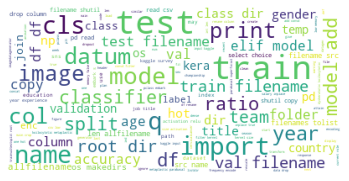

In [24]:
textTrue = str(dfAll['textAll'][dfAll['label'] == 'True'])
textFalse = str(dfAll['textAll'][dfAll['label'] == 'False'])
show_wordcloud(textTrue)

Wordcloud of False data.



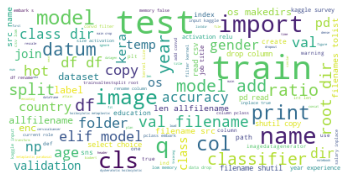

In [25]:
print(f'Wordcloud of False data.\n')
show_wordcloud(textFalse)

In [26]:
del textFalse, textTrue
gc.collect()

5165

<a id='svd'></a>

---
# 7. TruncatedSVD

---

[Back to Contents](#top)

In [27]:
scaler = StandardScaler(with_mean=False)  # https://www.haya-programming.com/entry/2020/02/08/073241
scaler.fit(xTrain)
dump_load(scaler, 'scaler.pkl', 'wb')

xTrainScaled = scaler.transform(xTrain)

In [28]:
svd = TruncatedSVD(n_components=2)
svd.fit(xTrainScaled)
dump_load(svd, 'svd.pkl', 'wb')

xTrainSVD = svd.transform(xTrainScaled)
print("Original shape: {}".format(str(xTrainScaled.shape)))
print("Reduced shape: {}".format(str(xTrainSVD.shape)))

Original shape: (63556, 27936)
Reduced shape: (63556, 2)


Text(0, 0.5, 'Second principal component')

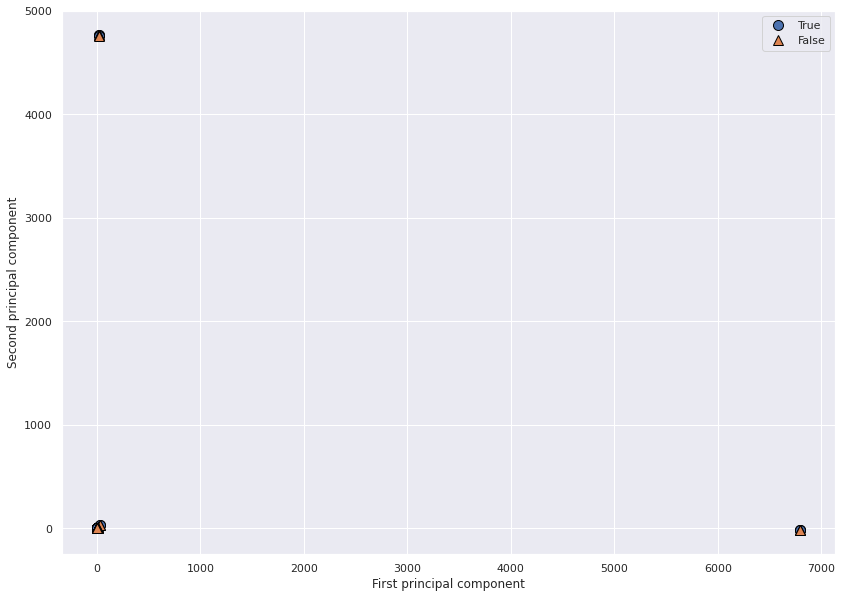

In [29]:
plt.figure(figsize=(15, 10))
mglearn.discrete_scatter(xTrainSVD[:, 0], xTrainSVD[:, 1], yTrain)
plt.legend(['True', 'False'], loc="best")
plt.gca().set_aspect("equal")
plt.xlabel("First principal component")
plt.ylabel("Second principal component")

In [30]:
listSVD = ['SVD_'+str(i) for i in range(1, 3)]
dfSVD = pd.DataFrame(xTrainSVD, columns=listSVD)
dfAll = pd.concat([dfAll, dfSVD], axis=1)

In [31]:
del dfSVD, listSVD, xTrainSVD
gc.collect()

42

<a id='tsne'></a>

---
# 8. t-sne

---

[Back to Contents](#top)

In [32]:
tsne = TSNE(random_state=42)
xTrainTsne = tsne.fit_transform(xTrainScaled)

Text(0, 0.5, 't-SNE feature 1')

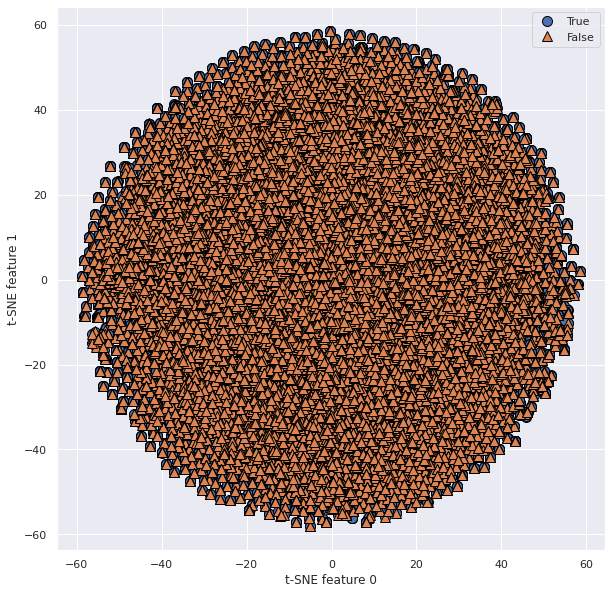

In [33]:
plt.figure(figsize=(10, 10))
mglearn.discrete_scatter(xTrainTsne[:, 0], xTrainTsne[:, 1], yTrain)
plt.legend(['True', 'False'], loc="best")
plt.gca().set_aspect("equal")
plt.xlabel("t-SNE feature 0")
plt.ylabel("t-SNE feature 1")

<a id='umap'></a>

---
# 9. UMAP

---

[Back to Contents](#top)

In [34]:
um = umap.UMAP(n_components=2)
um.fit(xTrainScaled)
dump_load(um, 'umap.pkl', 'wb')

xTrainUM = um.transform(xTrainScaled)

Text(0, 0.5, 'UMAP feature 1')

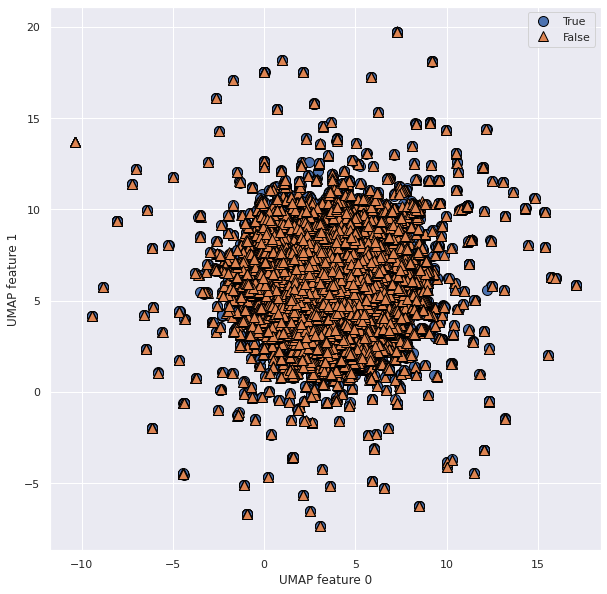

In [35]:
plt.figure(figsize=(10, 10))
mglearn.discrete_scatter(xTrainUM[:, 0], xTrainUM[:, 1], yTrain)
plt.legend(['True', 'False'], loc="best")
plt.gca().set_aspect("equal")
plt.xlabel("UMAP feature 0")
plt.ylabel("UMAP feature 1")

In [36]:
listUMAP = ['UMAP_'+str(i) for i in range(1, 3)]
dfUMAP = pd.DataFrame(xTrainUM, columns=listUMAP)
dfAll = pd.concat([dfAll, dfUMAP], axis=1)

In [37]:
del dfUMAP, xTrainUM, listUMAP
gc.collect()

210717

<a id='cosi'></a>

---
# 10. Cosine Similality

---

[Back to Contents](#top)

In [38]:
vectCode1 = vectorizer.transform(dfAll['code1'])
vectMD = vectorizer.transform(dfAll['markdown'])
vectCode2 = vectorizer.transform(dfAll['code2'])

In [39]:
for i in range(dfAll.shape[0]):
    cosSim1 = cosine_similarity(vectCode1[i], vectMD[i])
    cosSim2 = cosine_similarity(vectMD[i], vectCode2[i])
    cosSimRow = np.append(cosSim1, cosSim2).reshape(-1,2)
    if i == 0:
        cosSimAll = cosSimRow
    else:
        cosSimAll = np.concatenate([cosSimAll, cosSimRow], 0)

dfCosSim = pd.DataFrame(data=cosSimAll, columns=['cos_sim1', 'cos_sim2'])
dfAll = pd.concat([dfAll, dfCosSim], axis=1)

<AxesSubplot:xlabel='cos_sim1', ylabel='cos_sim2'>

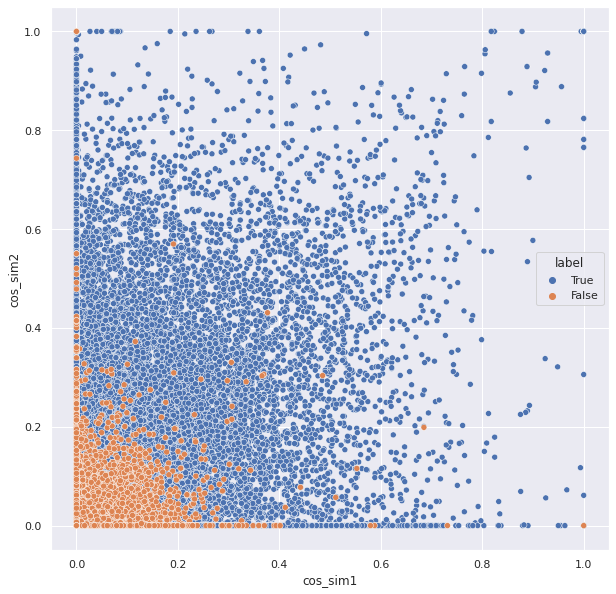

In [40]:
plt.figure(figsize=(10, 10))
sns.scatterplot(data=dfAll, x='cos_sim1', y='cos_sim2', hue='label')

In [41]:
dfAll.to_csv('dfAll.csv')
dfAll

,code1,markdown,code2,label,textAll,lda_1,lda_2,lda_3,lda_4,lda_5,lda_6,lda_7,lda_8,lda_9,lda_10,SVD_1,SVD_2,UMAP_1,UMAP_2,cos_sim1,cos_sim2
0,function for create train validation test folder one time use only def trainvaltestsplit root dir class dir main crop val ratio . test ratio . for cls in class dir create split folder os.makedirs train cls os.makedirs val cls os.makedirs test cls folder to copy image from src os.path.join root dir cls main split the file in the give ratio allfilename os.listdir src np.random.shuffle allfilename train filename val filename test filename np.split np.array allfilename int len allfilename val ratio test ratio int len allfilename test ratio train filename src name for name in train filenames.tolist val filename src name for name in val filenames.tolist test filename src name for name in test filenames.tolist print the split detail print cls print total image len allfilename print training len train filename print validation len val filename print test len test filename copy pasting image for name in train filename shutil.copy name train cls for name in val filename shutil.copy name val cls for name in test filename shutil.copy name test cls print preform train validation test split root dir . cervicalcancer dataset root folder class dir dyskeratotic koilocytotic metaplastic parabasal superficial intermediate class trainvaltestsplit root dir class dir,building model,import kera for image classification import kera from keras.layer import dense convd flatten maxpoold dropout from keras.model import sequential from keras.preprocessing import image from keras.callbacks import modelcheckpoint from keras.model import load model,True,function for create train validation test folder one time use only def trainvaltestsplit root dir class dir main crop val ratio . test ratio . for cls in class dir create split folder os.makedirs train cls os.makedirs val cls os.makedirs test cls folder to copy image from src os.path.join root dir cls main split the file in the give ratio allfilename os.listdir src np.random.shuffle allfilename train filename val filename test filename np.split np.array allfilename int len allfilename val ratio test ratio int len allfilename test ratio train filename src name for name in train filenames.tolist val filename src name for name in val filenames.tolist test filename src name for name in test filenames.tolist print the split detail print cls print total image len allfilename print training len train filename print validation len val filename print test len test filename copy pasting image for name in train filename shutil.copy name train cls for name in val filename shutil.copy name val cls for name in test filename shutil.copy name test cls print preform train validation test split root dir . cervicalcancer dataset root folder class dir dyskeratotic koilocytotic metaplastic parabasal superficial intermediate class trainvaltestsplit root dir class dir building model import kera for image classification import kera from keras.layer import dense convd flatten maxpoold dropout from keras.model import sequential from keras.preprocessing import image from keras.callbacks import modelcheckpoint from keras.model import load model,0.1603,0.0001,0.0001,0.0001,0.0001,0.0001,0.5009,0.0001,0.0001,0.3381,0.0091,0.0028,5.3244,6.0702,0.0000,0.0632
1,root dir . cervicalcancer class dyskeratotic koilocytotic metaplastic parabasal superficial intermediate def getdatasetsize path class main crop num of image { } for cls in class count the number of file in the folder num of image cls len os.listdir os.path.join path cls main return num of image print getdatasetsize root dir class complete,split the dataset such that we have for train datum for validation datum for testing datum,function for create train validation test folder one time use only def trainvaltestsplit root dir class dir main crop val ratio . test ratio . for cls in class dir create split folder os.makedirs train cls os.makedirs v

In [42]:
# Show variables and their memory usage
'''
print("{}{: >25}{}{: >10}{}".format('|','Variable Name','|','Memory','|'))
print(" ------------------------------------ ")
for var_name in dir():
    if not var_name.startswith("_"):
        print("{}{: >25}{}{: >10}{}".format('|',var_name,'|',sys.getsizeof(eval(var_name)),'|'))
'''

'\nprint("{}{: >25}{}{: >10}{}".format(\'|\',\'Variable Name\',\'|\',\'Memory\',\'|\'))\nprint(" ------------------------------------ ")\nfor var_name in dir():\n    if not var_name.startswith("_"):\n        print("{}{: >25}{}{: >10}{}".format(\'|\',var_name,\'|\',sys.getsizeof(eval(var_name)),\'|\'))\n'

<a id='conclusion'></a>

---
# 11. Conclusion

Thank you for your checking this notebook.

If you find an interesting thing here, please click upvote :)

---

[Back to Contents](#top)

<a id='ref'></a>

---
# 12. Reference
1. [Getting Started with AI4Code](https://www.kaggle.com/code/ryanholbrook/getting-started-with-ai4code)
2. [introduction_to_ml_with_python: 07-working-with-text-data](https://github.com/amueller/introduction_to_ml_with_python/blob/master/07-working-with-text-data.ipynb)

---

[Back to Contents](#top)